<a href="https://colab.research.google.com/github/jiwon-min98/LearningPyTorch/blob/main/04_PyTorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Notebook

In [174]:
import torch
from torch import nn

torch.__version__


'2.0.1+cu118'

In [175]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our data starts with 3 classes of food and only 10% of the images

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [176]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} directory doesn't exist... creating one")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path/"pizza_steak_sushi.zip",  "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# unzip
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak, sushi data...


## 2. Becoming one with the data (data preparation and exploration)

In [177]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contens"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [178]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [179]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1. get all of the image paths
2. pick a random image paht using a Python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. since we're working with images, let's open the image with Python's PIL
5. show the image and print metadata

data/pizza_steak_sushi/test/pizza/971934.jpg
pizza
random image path: data/pizza_steak_sushi/test/pizza/971934.jpg
image class: pizza
image height: 512
image width:512


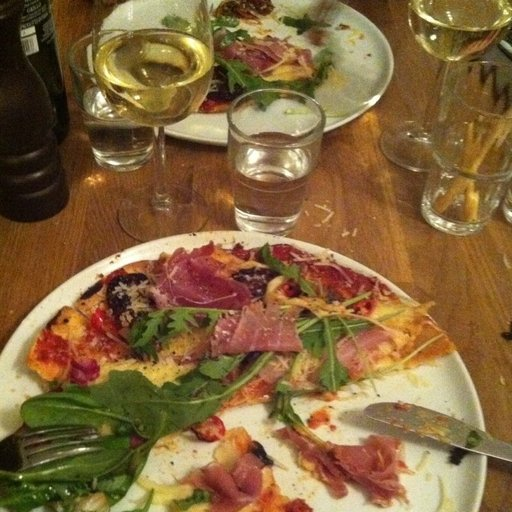

In [180]:
import random
from PIL import Image

random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image paht
random_image_path = random.choice(image_path_list)
print(random_image_path)

# get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. open image
img = Image.open(random_image_path)

# 5. print metadata
print(f"random image path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width:{img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

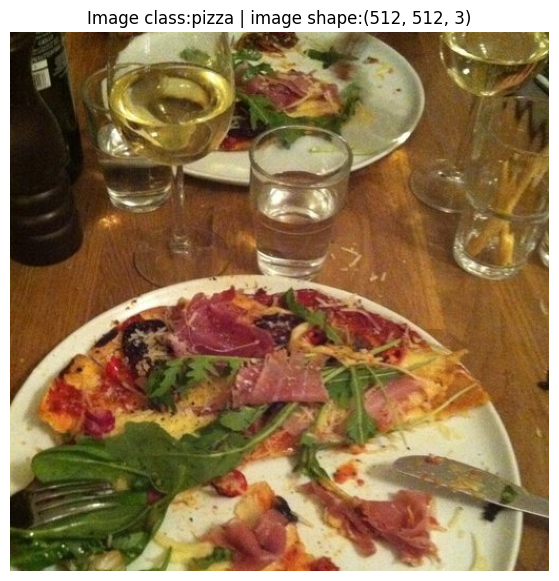

In [181]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class:{image_class} | image shape:{img_as_array.shape}")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:
1. turn your target data into tensors
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [182]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [183]:
# write a transform for image
data_transform = transforms.Compose([
    # resize our images to 64xt64
    transforms.Resize(size=(64,64)),
    # flip the image randomly on the horizonal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [184]:
data_transform(img)

tensor([[[0.5725, 0.6196, 0.4824,  ..., 0.1176, 0.1176, 0.1294],
         [0.6941, 0.5569, 0.4588,  ..., 0.1059, 0.1098, 0.1373],
         [0.6314, 0.6157, 0.4941,  ..., 0.1373, 0.0824, 0.1059],
         ...,
         [0.4157, 0.4471, 0.4706,  ..., 0.1725, 0.1725, 0.1725],
         [0.4157, 0.4392, 0.4549,  ..., 0.2039, 0.2196, 0.2196],
         [0.4078, 0.4157, 0.4235,  ..., 0.1647, 0.2118, 0.3373]],

        [[0.5373, 0.5765, 0.3922,  ..., 0.0902, 0.0863, 0.0941],
         [0.6627, 0.5059, 0.3686,  ..., 0.0863, 0.0784, 0.1059],
         [0.6000, 0.5608, 0.4157,  ..., 0.1137, 0.0549, 0.0784],
         ...,
         [0.2863, 0.3137, 0.3333,  ..., 0.2510, 0.2235, 0.1843],
         [0.2784, 0.3059, 0.3216,  ..., 0.2941, 0.2863, 0.2667],
         [0.2863, 0.2863, 0.2941,  ..., 0.2471, 0.2549, 0.3804]],

        [[0.2431, 0.2784, 0.1569,  ..., 0.0353, 0.0314, 0.0353],
         [0.3608, 0.2510, 0.1529,  ..., 0.0353, 0.0314, 0.0431],
         [0.3294, 0.2941, 0.2078,  ..., 0.0549, 0.0196, 0.

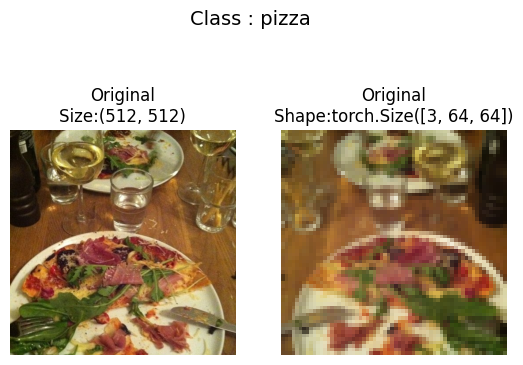

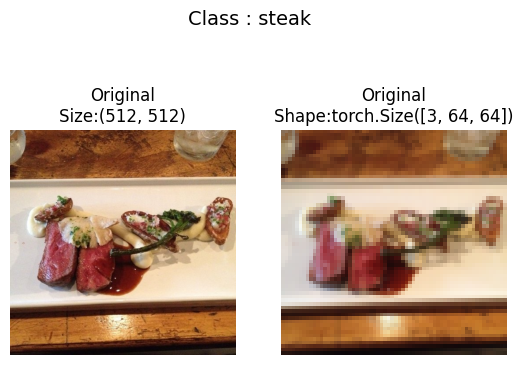

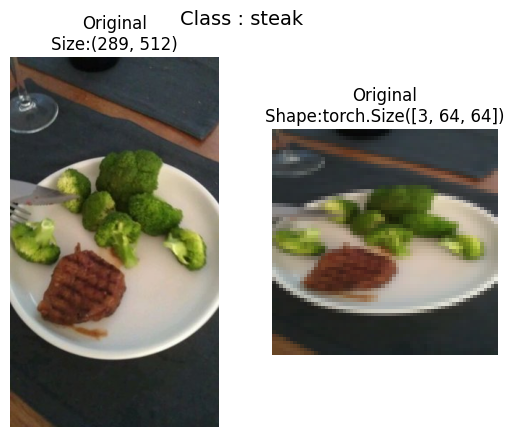

In [185]:
def plot_transformed_images(image_paths:list, transform, n=3,seed=42):
  """
  Selects random images from a path of images and loads/transforms them then plots the origianl vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)

      # transform and plot target image
      transformed_image=transform(f)
      ax[1].imshow(transformed_image.permute(1,2,0))
      ax[1].set_title(f"Original\nShape:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class : {image_path.parent.stem}", fontsize = 14)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [186]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [187]:
# Get class names as int
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [188]:
# get class names as dict
class_dict= train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [189]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [190]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [191]:
# Index on the train_data Dataset to get a single image and label
img,label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape:{img.shape}")
print(f"Image datatype:{img.dtype}")
print(f"Image label:{label}")
print(f"Label datatype:{type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape:torch.Size([3, 64, 64]) -> [color, height,weight]
permuted shape:torch.Size([64, 64, 3]) -> [height,weight, color]


Text(0.5, 1.0, 'pizza')

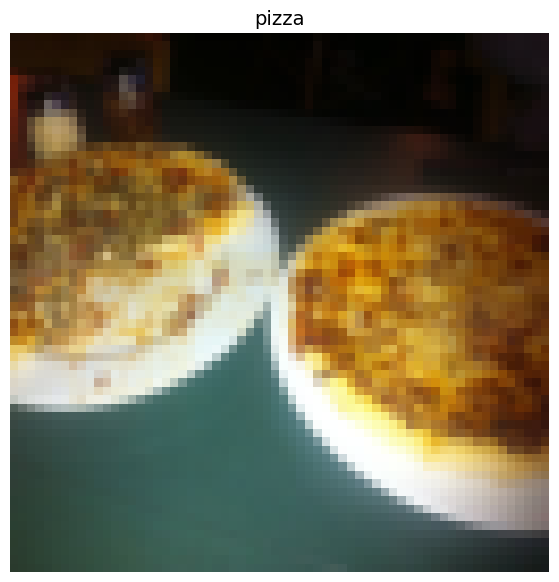

In [192]:
# rearrange the order of dimensions
img_permute = img.permute(1,2,0)
print(f"Original shape:{img.shape} -> [color, height,weight]")
print(f"permuted shape:{img_permute.shape} -> [height,weight, color]")

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### 4.1 turn loaded images into `Dataloader`s

A DataLoader is going to help us turn out `Dataset` into iterables and we can customise the `batch_size` so our model can look at images at a time

In [193]:
# turn train and test data sets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader= DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a5be1729720>,
 <torch.utils.data.dataloader.DataLoader at 0x7a5be172b430>)

In [194]:
img, label = next(iter(train_dataloader))

print(f"Image shape:{img.shape} ->[batch_size, color_channels , height, width]")
print(f"Label shape:{label.shape}")

Image shape:torch.Size([32, 3, 64, 64]) ->[batch_size, color_channels , height, width]
Label shape:torch.Size([32])


## 5. Option 2: loading image dat with Custom `Dataset`

1. load images from file
2. get class names from the dataset
3. get classes as dictionary from the dataset

pros:
* can create a `Dataset` out of almost anything
* not limited to PyTorch pre-built `Dataset` functions

cons:
* it doesn't mean it will work
* you will have to write more code, which could be more prone to errors or performance issues

In [195]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

### 5.1 Creating a helper function to get class names

we want a function to
1. get the class names using `os.scandir()` to traverse a target directory
2. raise an error if the class names are not found
3. turn the class names into a dict and a list and return them

In [196]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [197]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
  """ finds the class folder names in a target directory"""
  # 1. get the class naems by scanneing the target dir
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. raise an error if class names are not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. create a dict of index labels
  class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [198]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create out own custom dataset, we watn to:
1. subclass `torch.utils.data.dataset`
2. Init our subclass with a target directory
3. Create several attributes:
  * paths
  * transforms
  * classes
  * class_to_ids
4. Create a function to `load_images()`
5. Overwrite the `__len()__` method to retrun the length of our datset
6. overwrite the `__getitem()__` method to return a given sampel when passed an index

In [199]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [200]:
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [201]:
train_data_custom = ImageFolderCustom(targ_dir= train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                      transform = test_transforms)

### 5.3 Create a function to display random images

1. take in a `Dataset` and a number of other parameters
2. to prevent the display getting out of hand , let's cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the targe dataset
5. Setup a matplolib plt
6. Loop through the random sample images and plto them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib

In [202]:
# 1. create a function to take in a dataset
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n: int =10,
                          display_shape:bool=True,
                          seed:int=None):
  # 2. Adjust display if n is too high
  if n>10:
    n=10
    display_shape=False
    print(f"For display purposes, n shouldn't be larget than 10, setting to 10")

  # 3. set the seed
  if seed:
    random.seed(seed)

  # 4. get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot htem with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    if classes:
      title=f"Class:{classes[targ_label]}"
      if display_shape:
        title = title+f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

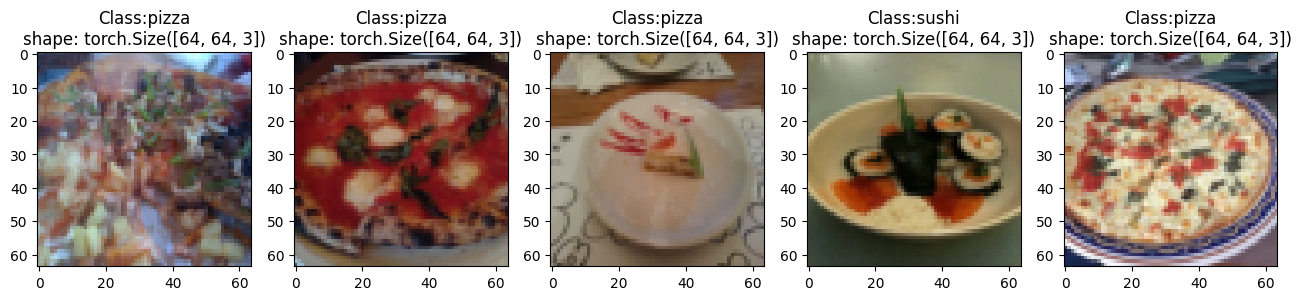

In [203]:
# display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

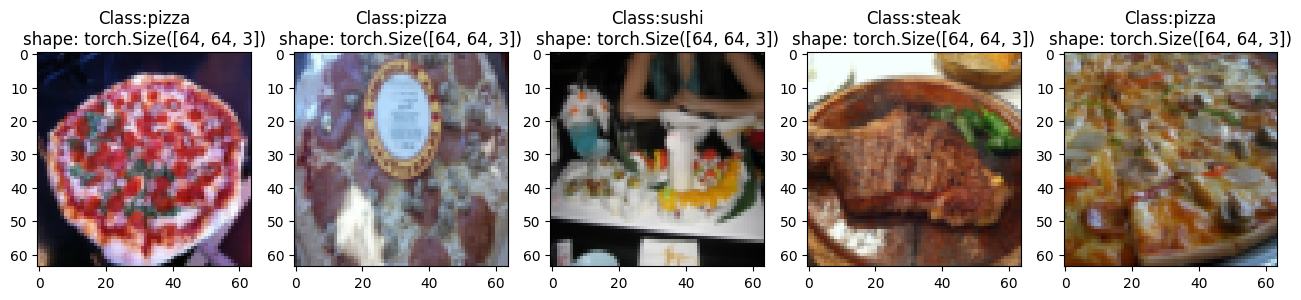

In [204]:
# Display randome images from ImageFolderCustom created Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 Turn costom loaded images into DataLoaders

In [205]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x7a5c02d17310>,
 <torch.utils.data.dataloader.DataLoader at 0x7a5c02d17dc0>)

In [206]:
# get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (Data Augmentation)

Data augmentation is the process of artificially adding diversit to your training data.

In the case of image data, htis may mean applying various transformations to the training images.

Let's take a look at one particular type of data augmentaiotn used to train pyTorch vision models to state of the art levels...



In [207]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [208]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg')]

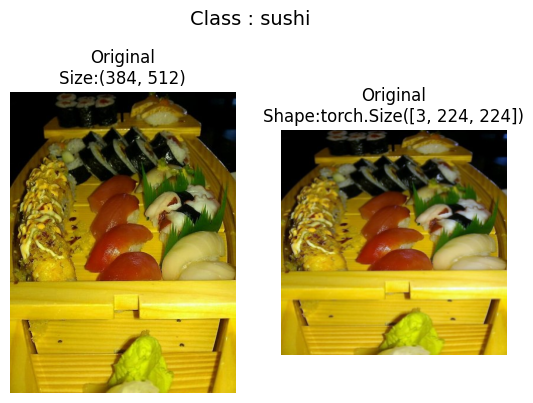

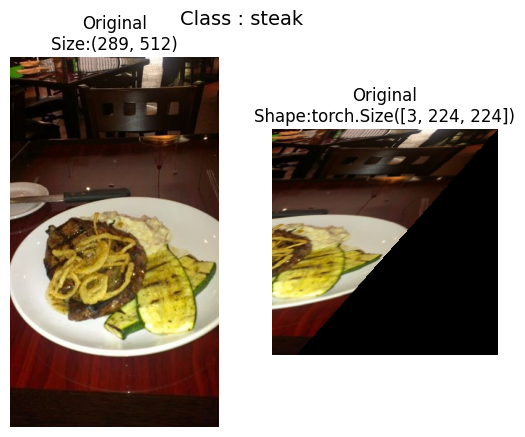

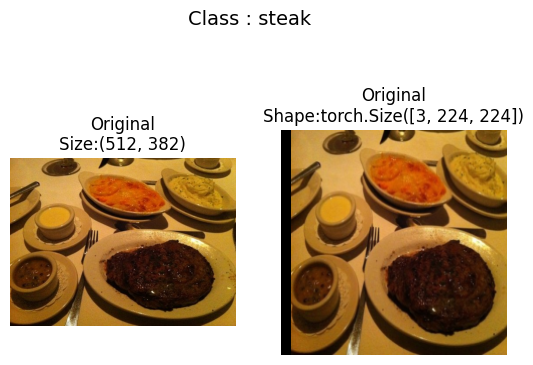

In [209]:
plot_transformed_images(
    image_paths=image_path_list,
    transform = train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [210]:
# create simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [211]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)
test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# 2. trun the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers= NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers= NUM_WORKERS)

In [212]:
### 7.2 Create TinyVGG Model Class
class TinyVGG(nn.Module):
  """
  Model architecture copying tinyVGG freom CNN Explainer
  """
  def __init__(self, input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels= hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels= hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels= hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels= hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*16*16,
                  out_features= output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [213]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image

In [214]:
image_batch, label_batch= next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [215]:
model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [216]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loops function


In [225]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [226]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine train step and test step

In [227]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 train and evaluate model 0

In [228]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1435 | test_acc: 0.1979
Total training time: 6.110 seconds


### 7.8 Plot the loss curves of Model 0

In [229]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [230]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

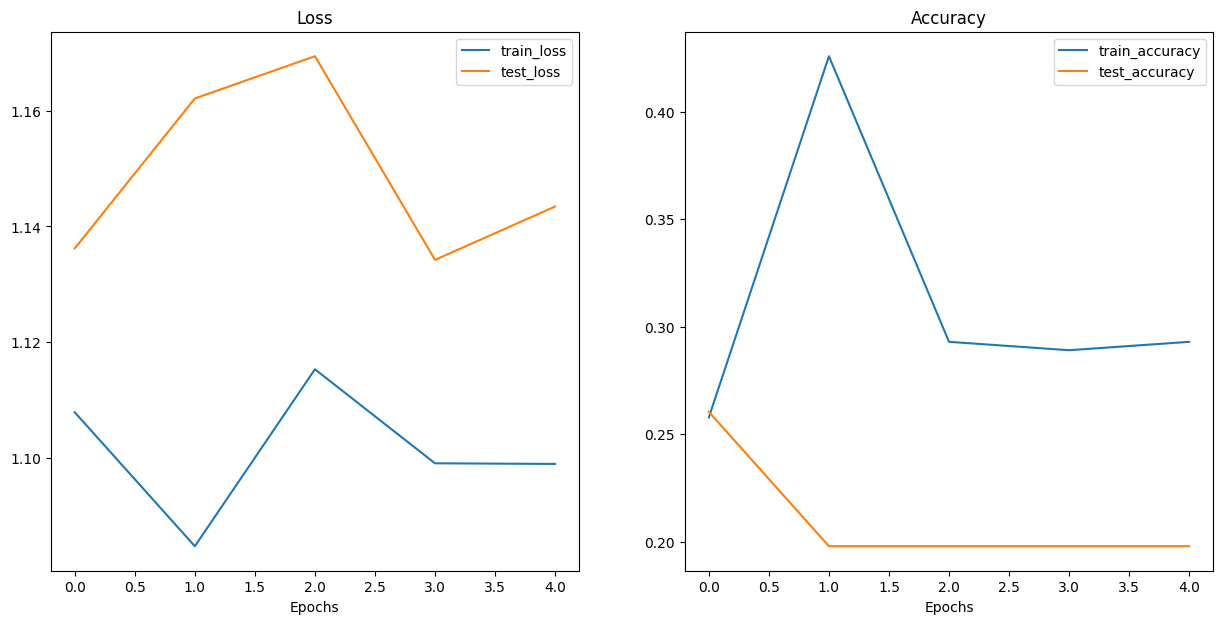

In [231]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation


### 9.1 Create transform with data augmentation

In [233]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test Dataset's and DataLoader's

In [235]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [236]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a5c021025c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a5be172b430>)

### 9.3 Construct and train Model 1

In [238]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [239]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1388 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1293 | train_acc: 0.3047 | test_loss: 1.1625 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1481 | test_acc: 0.2604
Total training time: 7.106 seconds


### 9.4 Plot the loss curves of Model 1

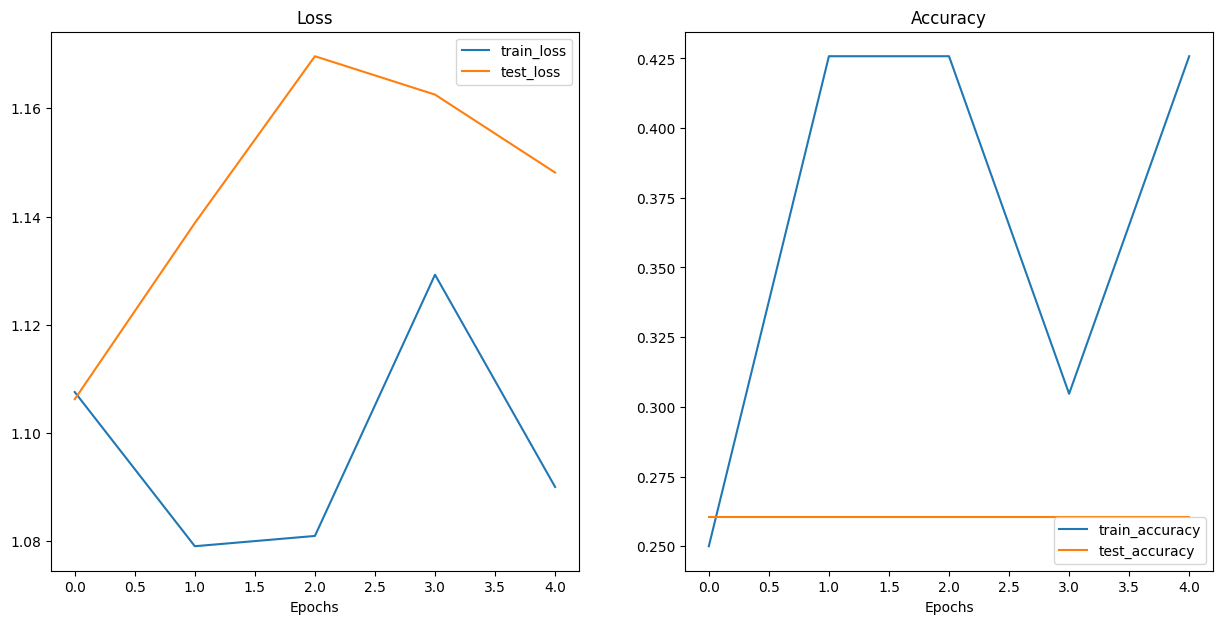

In [240]:
plot_loss_curves(model_1_results)

### 10. Compare model results

In [242]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084645,0.425781,1.162168,0.197917
2,1.115279,0.292969,1.169480,0.197917
3,1.099000,0.289062,1.134218,0.197917
4,1.098894,0.292969,1.143456,0.197917


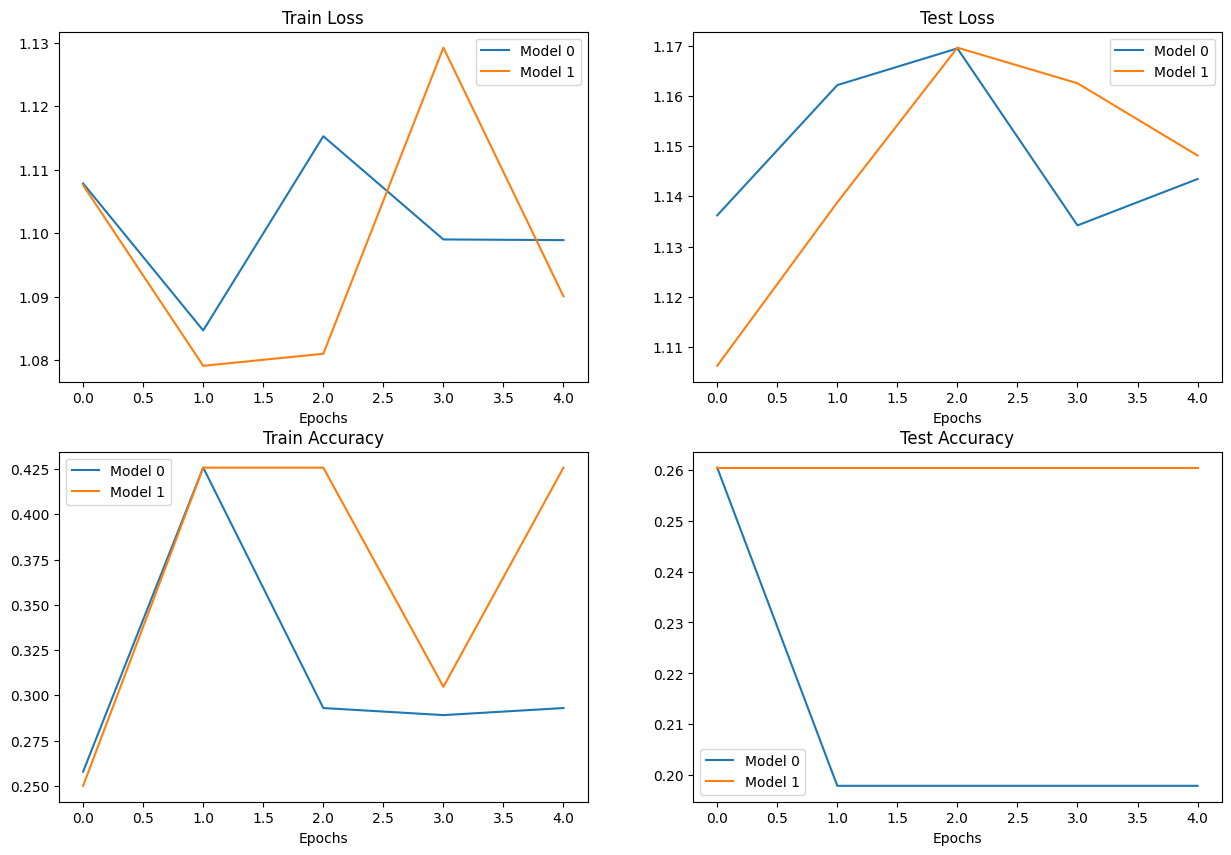

In [243]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make a prediction on a custom image

In [245]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [248]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

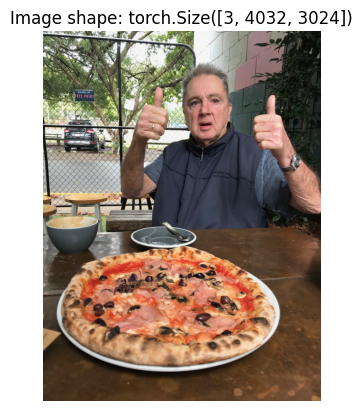

In [250]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [251]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [253]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [254]:
custom_image_pred

tensor([[ 0.1162,  0.0335, -0.1417]], device='cuda:0')

In [255]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1162,  0.0335, -0.1417]], device='cuda:0')
Prediction probabilities: tensor([[0.3713, 0.3418, 0.2869]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [256]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [257]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3713, 0.3418, 0.2869]], device='cuda:0')

In [258]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

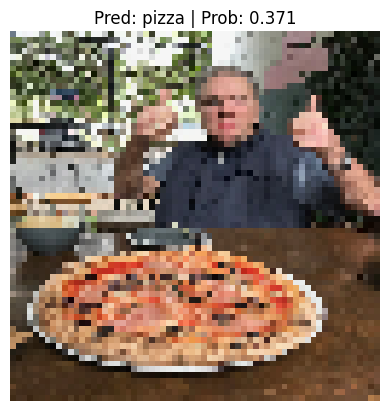

In [259]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)